In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_matches = pd.read_csv('../../data/engineered/raw_engineered_features.csv')
df_matches.sort_values(by=["season", "stage", "date"], inplace=True)

season_dummies = pd.get_dummies(df_matches['season'], prefix='season', drop_first=True)
df_matches = df_matches.join(season_dummies)

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_score

def transform_to_poly_features(X_trn, X_val, X_tst):
    # Configure polynomial features for top interactions
    poly_features = [
        'points_difference',
        'team_acceleration_home',
        'team_strength_away',
        'away_last_team_possession'
    ]

    poly_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=2,
                                    interaction_only=True,
                                    include_bias=False))
    ])

    # Apply to selected columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('poly', poly_transformer, poly_features)
        ],
        remainder='passthrough',
        force_int_remainder_cols=False
    )

    # Create preprocessing-only pipeline
    preprocessing_pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

    # Fit and transform data
    X_train_processed = preprocessing_pipeline.fit_transform(X_trn)
    X_val_processed = preprocessing_pipeline.transform(X_val)
    X_test_processed = preprocessing_pipeline.transform(X_tst)

    # Get readable feature names
    feature_names = preprocessing_pipeline.named_steps['preprocessor'].get_feature_names_out()

    # Create processed DataFrames
    trn_df = pd.DataFrame(X_train_processed, columns=feature_names)
    val_df = pd.DataFrame(X_val_processed, columns=feature_names)
    tst_df = pd.DataFrame(X_test_processed, columns=feature_names)

    # Convert all columns to numeric, coercing errors to NaN if needed
    trn_df = trn_df.apply(pd.to_numeric, errors='coerce')
    val_df = val_df.apply(pd.to_numeric, errors='coerce')
    tst_df = tst_df.apply(pd.to_numeric, errors='coerce')

    return trn_df, val_df, tst_df


def train_and_evaluate(train_df, val_df, test_df, season, stage):
    feature_cols = [col for col in train_df.columns if col not in
                    ["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"]]

    X_train = train_df[feature_cols]
    y_train = train_df["result_match"]

    X_val = val_df[feature_cols]
    y_val = val_df["result_match"]

    X_test = test_df[feature_cols]
    y_test = test_df["result_match"]

    X_trn, X_validation, X_tst = transform_to_poly_features(X_train, X_val, X_test)

    params = {'colsample_bytree': 0.8644921558123839,
              'gamma': 3.1561936524648697,
              'learning_rate': 0.2642696313597313,
              'max_depth': 9,
              'n_estimators': 600,
              'reg_alpha': 0.17990842862746917,
              'reg_lambda': 0.14948766090841384,
              'subsample': 0.8442401328493275
              }

    model = XGBClassifier(
        **params,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",

    )

    model.fit(X_trn, y_train, eval_set=[(X_trn, y_train), (X_validation, y_val)], verbose=False)
    y_pred = model.predict(X_tst)
    f1 = precision_score(y_test, y_pred, average="binary", zero_division=0)

    return f1, season, stage, y_test.tolist(), y_pred.tolist()

In [4]:
# ---------------------
# Backtesting over multiple seasons
# ---------------------

seasons = sorted(df_matches["season"].unique(), reverse=True)
backtest_results = []

for i in range(1, len(seasons)):
    target_season = seasons[0]
    previous_seasons = seasons[1:1 + i]

    target_season_df = df_matches[df_matches["season"] == target_season]

    target_stages = sorted(target_season_df["stage"].unique())

    for stage in target_stages:
        if stage <= min(target_stages) + 1:
            continue

        train_df_prev = df_matches[df_matches["season"].isin(previous_seasons)]
        train_df_target = target_season_df[target_season_df["stage"] < (stage - 1)]
        train_df = pd.concat([train_df_prev, train_df_target], ignore_index=True)

        val_df = target_season_df[target_season_df["stage"] == (stage - 1)]
        test_df = target_season_df[target_season_df["stage"] == stage]

        if train_df.empty or val_df.empty or test_df.empty:
            continue

        f1, season, stage, y_test, y_pred = train_and_evaluate(train_df, val_df, test_df, target_season, stage)

        backtest_results.append({
            "season": f"{season} - {len(previous_seasons)}",
            "stage": stage,
            "train_size": len(train_df),
            "f1_score": f1,
            "y_test": y_test,
            "y_pred": y_pred
        })

results_df = pd.DataFrame(backtest_results)
print("Backtesting results for each season and stage:")

Backtesting results for each season and stage:


In [5]:
results_df.to_csv('stages_results.csv', index=False)

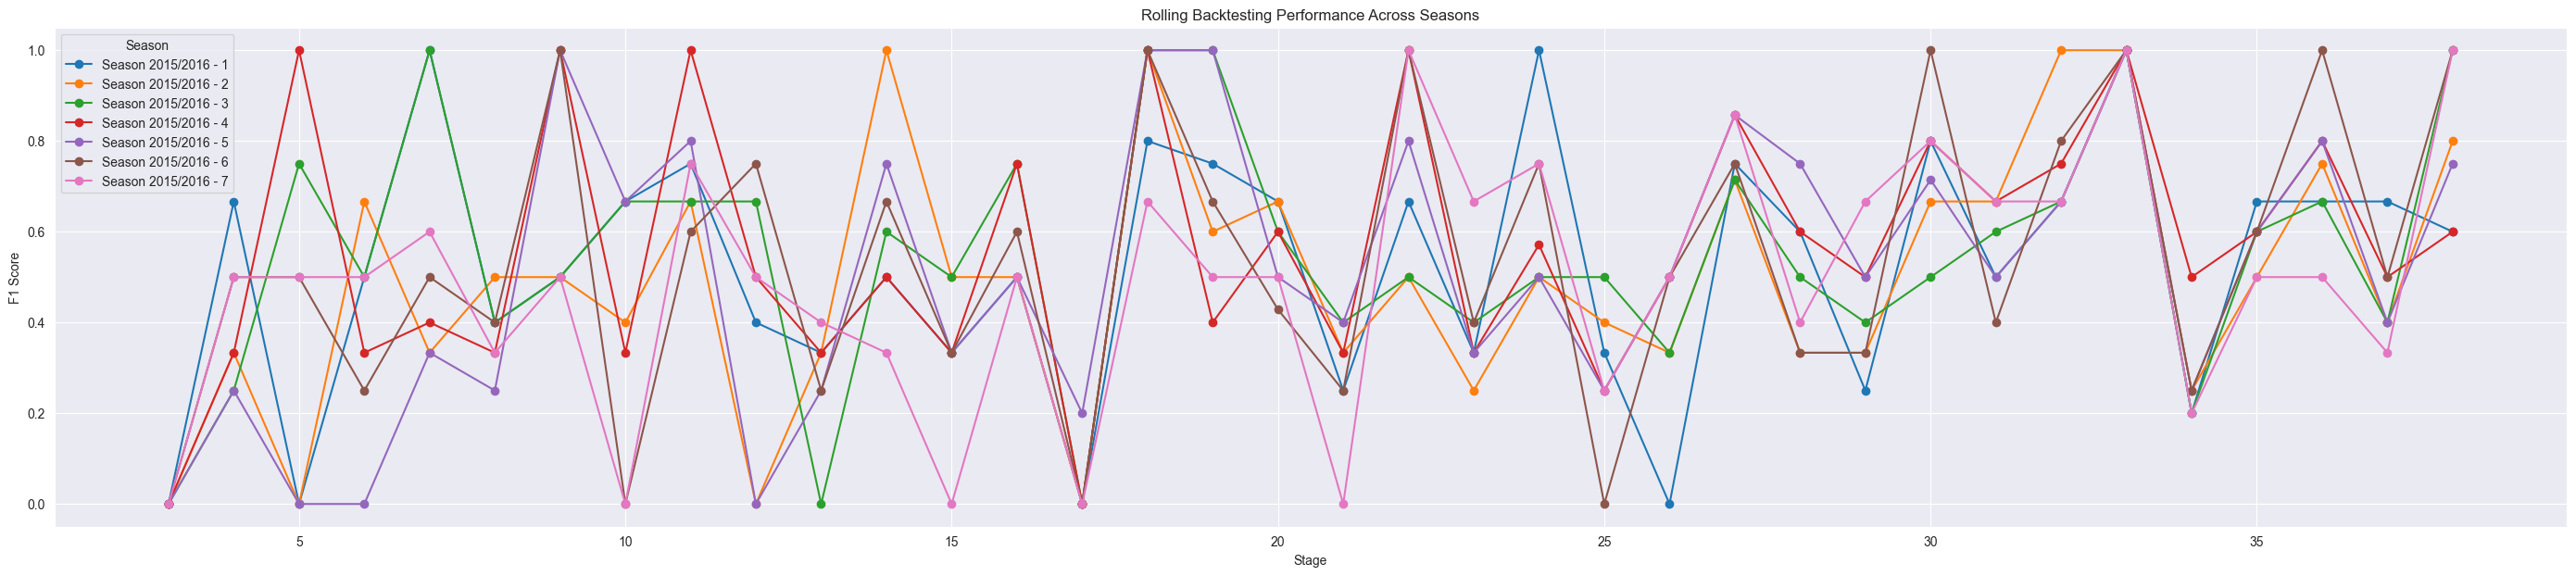

In [6]:
plt.figure(figsize=(35, 7))
for season in results_df["season"].unique():
    season_results = results_df[results_df["season"] == season]
    plt.plot(season_results["stage"], season_results["f1_score"], marker="o", label=f"Season {season}")

plt.xlabel("Stage")
plt.ylabel("F1 Score")
plt.title("Rolling Backtesting Performance Across Seasons")
plt.legend(title="Season")
plt.grid(True)
plt.show()


Average F1 Score for each season:
          season  avg_f1_score
0  2015/2016 - 1      0.519907
1  2015/2016 - 2      0.492526
2  2015/2016 - 3      0.548082
3  2015/2016 - 4      0.564220
4  2015/2016 - 5      0.511243
5  2015/2016 - 6      0.536442
6  2015/2016 - 7      0.495569


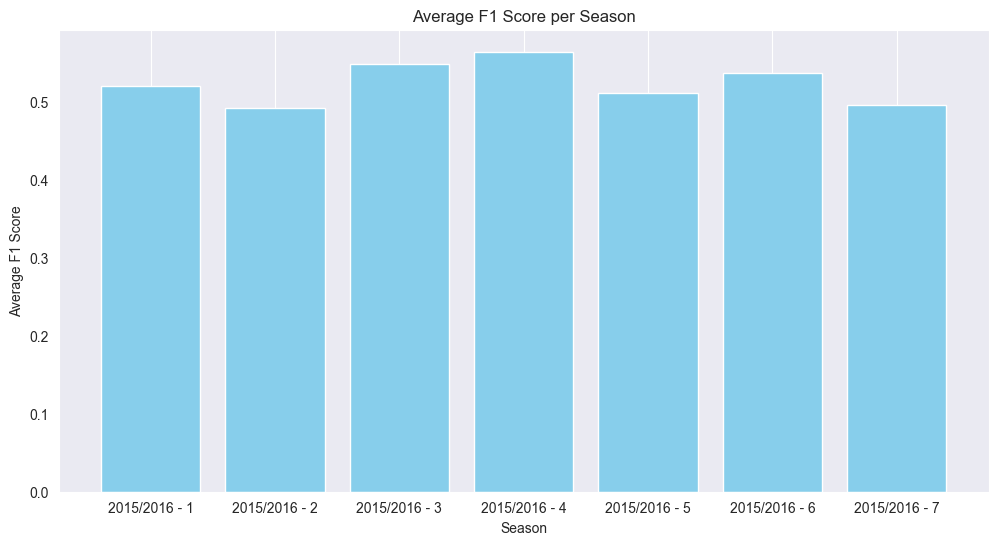

In [7]:
avg_results = results_df.groupby("season")["f1_score"].mean().reset_index()
avg_results.rename(columns={"f1_score": "avg_f1_score"}, inplace=True)
print("\nAverage F1 Score for each season:")
print(avg_results)

plt.figure(figsize=(12, 6))
plt.bar(avg_results["season"].astype(str), avg_results["avg_f1_score"], color='skyblue')
plt.xlabel("Season")
plt.ylabel("Average F1 Score")
plt.title("Average F1 Score per Season")
plt.grid(axis='y')
plt.show()